Data analytics notebook using the Seattle Crime Statistics Dataset: https://www.kaggle.com/samharris/seattle-crime

# Pre-processing the Seattle Crime Statistics Dataset

In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import csv as csv
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, log_loss, average_precision_score

from textblob import TextBlob
from gensim import corpora, models, similarities

import logging

%matplotlib inline

/home/chris/anaconda3/lib/python3.5/site-packages/gensim/utils.py:1015: UserWarning: Pattern library is not installed, lemmatization won't be available.
  warnings.warn("Pattern library is not installed, lemmatization won't be available.")


In [3]:
# Display progress logs on stdout
logging.basicConfig(level=logging.INFO,
                    format='%(asctime)s %(levelname)s %(message)s')

In [4]:
# Set up my data directories from different machines

mac_data_dir = '/Users/christopherallison/Documents/Coding/Data'
linux_data_dir = '/home/chris/data'
win_data_dir = u'C:\\Users\\Owner\\Documents\\Data'

In [5]:
# Set data directory for example

data_dir = linux_data_dir

In [6]:
# Then we'll create a dictionary through which we can transform and revert the values to strings.
# We can also use the LabelEncoder() function - but this seems easier.

def transform_string_label_to_integer(dictionary, dataframe_column):
    # takes dictionary and dataframe column and returns translation dict
    for i, label in enumerate(dataframe_column.unique()):
        dictionary[label] = i

In [7]:
# Load TRAINING DATA

train_df = pd.read_csv(os.path.join(data_dir, 'SPD_Reports.csv'), header=0)        # Load the train file into a dataframe

In [8]:
# Data exploration - what headers do we have?

train_df.columns

Index(['Offense Type', 'Offense Description', 'Report Date',
       'Offense Start Date', 'Offense End Date', 'Block', 'District', 'Beat',
       '2000 Census Tract', 'Longitude', 'Latitude'],
      dtype='object')

In [9]:
# Let's look at our data

train_df.head()

,Offense Type,Offense Description,Report Date,Offense Start Date,Offense End Date,Block,District,Beat,2000 Census Tract,Longitude,Latitude
0,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-22T10:20:00,2016-08-21T22:30:00,2016-08-22T09:00:00,7XX BLOCK OF NW 58 ST,B,B2,3400.3006,-122.365631,47.670891
1,THEFT-LICENSE PLATE,OTHER PROPERTY,2016-08-27T17:25:00,2016-08-26T15:30:00,2016-08-27T15:00:00,18XX BLOCK OF 36 AV W,Q,Q1,5600.3037,-122.403702,47.635548
2,ASSLT-AGG-GUN,ASSAULT,2016-08-28T01:25:00,2016-08-28T01:25:00,NaN,5XX BLOCK OF 2 AV,K,K2,8100.1057,-122.332253,47.602013
3,THEFT-LICENSE PLATE,OTHER PROPERTY,2016-08-28T10:24:00,2016-08-27T21:30:00,2016-08-28T09:30:00,7XX BLOCK OF 35 AV,G,G2,7800.2026,-122.288322,47.608585
4,TRAFFIC,TRAFFIC,2016-08-28T02:14:00,2016-08-28T02:14:00,NaN,11 AV / E HOWELL ST,E,E2,7500.4001,-122.318199,47.617592


In [44]:
# First, let's fix up the date/time values so we can use them.

train_df['Report Date'] = pd.to_datetime(train_df['Report Date'], yearfirst=True)
train_df['Offense Start Date'] = pd.to_datetime(train_df['Offense Start Date'], yearfirst=True)
train_df['Offense End Date'] = pd.to_datetime(train_df['Offense End Date'], yearfirst=True)

In [47]:
train_df.head()

,Offense Type,Offense Description,Report Date,Offense Start Date,Offense End Date,Block,District,Beat,2000 Census Tract,Longitude,Latitude,New Report Date
0,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-22 10:20:00,2016-08-21 22:30:00,2016-08-22 09:00:00,7XX BLOCK OF NW 58 ST,B,B2,3400.3006,-122.365631,47.670891,2016-08-22 10:20:00
1,THEFT-LICENSE PLATE,OTHER PROPERTY,2016-08-27 17:25:00,2016-08-26 15:30:00,2016-08-27 15:00:00,18XX BLOCK OF 36 AV W,Q,Q1,5600.3037,-122.403702,47.635548,2016-08-27 17:25:00
2,ASSLT-AGG-GUN,ASSAULT,2016-08-28 01:25:00,2016-08-28 01:25:00,NaT,5XX BLOCK OF 2 AV,K,K2,8100.1057,-122.332253,47.602013,2016-08-28 01:25:00
3,THEFT-LICENSE PLATE,OTHER PROPERTY,2016-08-28 10:24:00,2016-08-27 21:30:00,2016-08-28 09:30:00,7XX BLOCK OF 35 AV,G,G2,7800.2026,-122.288322,47.608585,2016-08-28 10:24:00
4,TRAFFIC,TRAFFIC,2016-08-28 02:14:00,2016-08-28 02:14:00,NaT,11 AV / E HOWELL ST,E,E2,7500.4001,-122.318199,47.617592,2016-08-28 02:14:00


In [10]:
# And get a better overall feel for it.

train_df.describe()

/home/chris/anaconda3/lib/python3.5/site-packages/numpy/lib/function_base.py:3834: RuntimeWarning: Invalid value encountered in percentile
  RuntimeWarning)


,2000 Census Tract,Longitude,Latitude
count,682659.000000,684471.000000,684471.000000
mean,6888.187303,-122.330924,47.622330
std,3246.442326,0.030640,0.055096
min,100.100100,-122.423465,47.448597
25%,NaN,NaN,NaN
50%,NaN,NaN,NaN
75%,NaN,NaN,NaN
max,26500.100900,-122.217604,47.777795


The first thing we see from this are there are primarily text features - we'll need to do something about that for our analysis. (Machine learning requires integer fields)

Let's see how many unique offense types we're dealing with.

In [17]:
train_df['Offense Type'].unique()

array(['VEH-THEFT-AUTO', 'THEFT-LICENSE PLATE', 'ASSLT-AGG-GUN', 'TRAFFIC',
       'ASSLT-NONAGG', 'FRAUD-OTHER', 'PROPERTY FOUND', 'WARRARR-FELONY',
       'THEFT-BICYCLE', 'BURGLARY-NOFORCE-RES', 'THEFT-OTH',
       'FRAUD-CREDIT CARD', 'FRAUD-CHECK', 'THREATS-OTHER',
       'DISTURBANCE-OTH', 'THEFT-CARPROWL', 'EXTORTION', 'THEFT-SHOPLIFT',
       'VEH-THEFT-TRUCK', 'ASSLT-AGG-WEAPON',
       'PROPERTY DAMAGE-RESIDENTIAL', 'PROPERTY DAMAGE - GRAFFITI',
       'COUNTERFEIT', 'BURGLARY-FORCE-NONRES', 'WEAPON-POSSESSION',
       'BURGLARY-FORCE-RES', 'NARC-POSSESS-MARIJU', 'NARC-SELL-COCAINE',
       'ASSLT-AGG-BODYFORCE', 'BURGLARY-NOFORCE-NONRES', 'HARASSMENT',
       'PROPERTY DAMAGE-NON RESIDENTIA', 'VEH-RCVD-FOR OTHER AGENCY',
       'NARC-POSSESS-COCAINE', 'NARC-POSSESS-HEROIN', 'NARC-POSSESS-METH',
       'NARC-FOUND-PILL/TABLET', 'ROBBERY-BUSINESS-BODYFORCE',
       'BURGLARY-SECURE PARKING-RES', 'TRESPASS', 'WARRARR-MISDEMEANOR',
       'PROPERTY STOLEN-POSSESS', 'WEAPON-UNLAW

Okay.  That's a lot. Let's see exactly how many offenses we've got.

In [18]:
len(train_df['Offense Type'].unique())

200

In [68]:
# Let's take a look at the top offenses.

counts = train_df.groupby('Offense Type').count().reset_index()
sorted_counts = counts.sort_values('Block', ascending=False)
top_10 = sorted_counts.head(10)
top_10

,Offense Type,Offense Description,Report Date,Offense Start Date,Offense End Date,Block,District,Beat,2000 Census Tract,Longitude,Latitude
164,THEFT-CARPROWL,121113,121113,121113,101547,121113,121079,121079,120969,121113,121113
168,THEFT-OTH,43870,43870,43870,26516,43870,43848,43848,43803,43870,43870
181,VEH-THEFT-AUTO,38864,38864,38864,33651,38864,38854,38855,38798,38864,38864
120,PROPERTY DAMAGE-NON RESIDENTIA,32671,32671,32671,19175,32671,32658,32659,32651,32671,32671
15,BURGLARY-FORCE-RES,31485,31485,31485,19767,31485,31474,31474,31472,31485,31485
9,ASSLT-NONAGG,24963,24963,24963,3687,24963,24939,24939,24934,24963,24963
171,THEFT-SHOPLIFT,23264,23264,23264,3896,23264,23263,23263,23260,23264,23264
27,DISTURBANCE-OTH,22145,22145,22145,2947,22145,22132,22132,22125,22145,22145
122,PROPERTY FOUND,21675,21675,21675,2794,21675,21616,21616,21582,21675,21675
17,BURGLARY-NOFORCE-RES,20252,20252,20252,13574,20252,20246,20246,20245,20252,20252


In [50]:
# Now we'll take a closer look at our data more generally.

for col in train_df.columns:
    print(col, len(train_df[col].unique()), train_df[col].unique())
    print("******")

Offense Type 200 ['VEH-THEFT-AUTO' 'THEFT-LICENSE PLATE' 'ASSLT-AGG-GUN' 'TRAFFIC'
 'ASSLT-NONAGG' 'FRAUD-OTHER' 'PROPERTY FOUND' 'WARRARR-FELONY'
 'THEFT-BICYCLE' 'BURGLARY-NOFORCE-RES' 'THEFT-OTH' 'FRAUD-CREDIT CARD'
 'FRAUD-CHECK' 'THREATS-OTHER' 'DISTURBANCE-OTH' 'THEFT-CARPROWL'
 'EXTORTION' 'THEFT-SHOPLIFT' 'VEH-THEFT-TRUCK' 'ASSLT-AGG-WEAPON'
 'PROPERTY DAMAGE-RESIDENTIAL' 'PROPERTY DAMAGE - GRAFFITI' 'COUNTERFEIT'
 'BURGLARY-FORCE-NONRES' 'WEAPON-POSSESSION' 'BURGLARY-FORCE-RES'
 'NARC-POSSESS-MARIJU' 'NARC-SELL-COCAINE' 'ASSLT-AGG-BODYFORCE'
 'BURGLARY-NOFORCE-NONRES' 'HARASSMENT' 'PROPERTY DAMAGE-NON RESIDENTIA'
 'VEH-RCVD-FOR OTHER AGENCY' 'NARC-POSSESS-COCAINE' 'NARC-POSSESS-HEROIN'
 'NARC-POSSESS-METH' 'NARC-FOUND-PILL/TABLET' 'ROBBERY-BUSINESS-BODYFORCE'
 'BURGLARY-SECURE PARKING-RES' 'TRESPASS' 'WARRARR-MISDEMEANOR'
 'PROPERTY STOLEN-POSSESS' 'WEAPON-UNLAWFUL USE'
 'NARC-DRUG TRAFFIC LOITERING' 'NARC-POSSESS-AMPHETAMINE' 'THEFT-BUILDING'
 'NARC-FOUND-MARIJU' 'PROPERTY LO

In [21]:
# Let's look at one subset - the largest - vehicle theft

veh_theft = train_df[train_df["Offense Description"] == "VEHICLE THEFT"]
veh_theft

,Offense Type,Offense Description,Report Date,Offense Start Date,Offense End Date,Block,District,Beat,2000 Census Tract,Longitude,Latitude
0,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-22T10:20:00,2016-08-21T22:30:00,2016-08-22T09:00:00,7XX BLOCK OF NW 58 ST,B,B2,3400.3006,-122.365631,47.670891
7,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-28T11:31:00,2016-08-27T16:00:00,2016-08-28T11:00:00,8XX BLOCK OF W ETRURIA ST,Q,Q2,5900.2009,-122.369453,47.647785
8,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-28T13:28:00,2016-08-28T13:28:00,NaN,38XX BLOCK OF STONE WY N,B,B3,5400.4023,-122.342537,47.653412
11,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-06T07:23:00,2016-07-18T13:00:00,2016-07-18T16:00:00,22XX BLOCK OF WESTLAKE AV,D,D2,7300.3020,-122.338440,47.618244
28,VEH-THEFT-TRUCK,VEHICLE THEFT,2016-08-28T10:08:00,2016-08-27T22:00:00,2016-08-28T10:00:00,6XX BLOCK OF NW 77 ST,J,J2,2900.3005,-122.364670,47.684734
62,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-26T12:43:00,2016-08-26T00:00:00,2016-08-26T08:00:00,85XX BLOCK OF 8 AV S,F,F3,11200.2040,-122.322906,47.526890
66,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-28T09:17:00,2016-08-28T00:01:00,2016-08-28T09:00:00,117XX BLOCK OF 8 AV NE,L,L1,600.6006,-122.320724,47.714935
67,VEH-THEFT-AUTO,VEHICLE THEFT,2016-08-25T08:13:00,2016-08-24T19:00:00,2016-08-25T06:30:00,44XX BLOCK OF 39 AV SW,W,W2,9800.3030,-122.381454,47.563778
70,VEH-RCVD-FOR OTHER AGENCY,VEHICLE THEFT,2016-08-28T14:52:00,2016-08-28T10:16:00,NaN,37 PL NW / NW 57 ST,B,B1,3200.4011,-122.404091,47.670433
106,VEH-THEFT-TRUCK,VEHICLE THEFT,2016-07-09T22:37:00,2016-07-09T00:01:00,2016-07-09T08:00:00,107XX BLOCK OF AURORA AV N,N,N3,402.2014,-122.344719,47.706707


In [25]:
pd.crosstab(veh_theft['Offense Description'], veh_theft['Offense Type'])

Offense Type,THEFT-BOAT,VEH-RCVD-FOR OTHER AGENCY,VEH-THEFT-AUTO,VEH-THEFT-BUS,VEH-THEFT-HVYEQUIP,VEH-THEFT-MTRCYCLE,VEH-THEFT-OTHVEH,VEH-THEFT-RECREATION VEH,VEH-THEFT-TRAILER,VEH-THEFT-TRUCK
Offense Description,,,,,,,,,,
VEHICLE THEFT,197,4425,38864,2,23,2057,42,28,396,2982


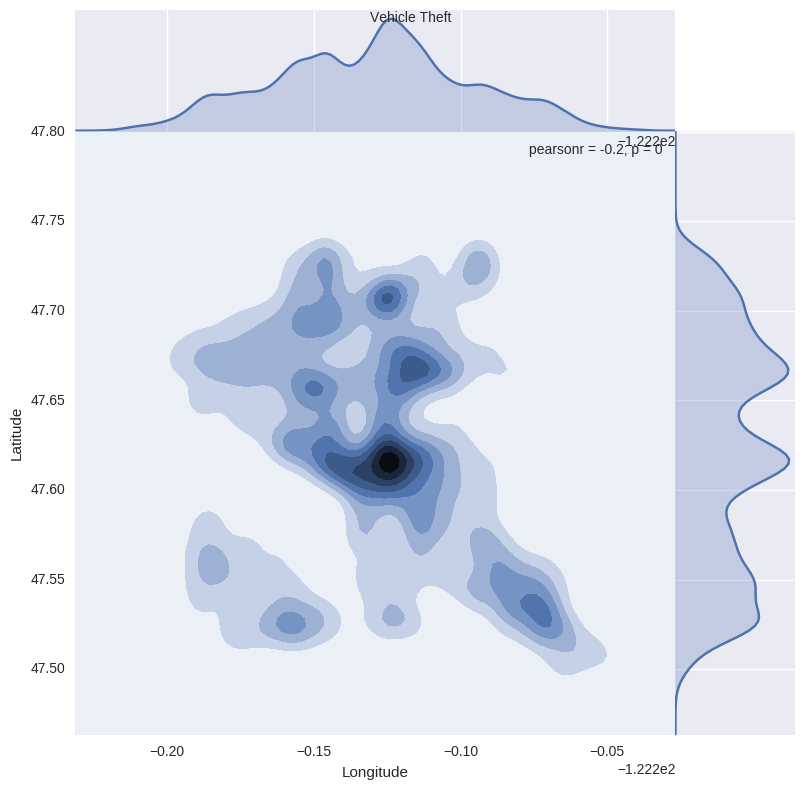

In [33]:
# Now let's take the vehicle theft description and plot it against the latitude and longitude using a kernel density estimate graph in Seaborn

plot = sns.jointplot("Longitude", "Latitude", data=veh_theft, kind="kde", size=8, space=0)
plot.fig.suptitle("Vehicle Theft")

So, now let's look at another offense type: assault.

In [34]:
assault = train_df[train_df["Offense Description"] == "ASSAULT"]
assault

,Offense Type,Offense Description,Report Date,Offense Start Date,Offense End Date,Block,District,Beat,2000 Census Tract,Longitude,Latitude
2,ASSLT-AGG-GUN,ASSAULT,2016-08-28T01:25:00,2016-08-28T01:25:00,NaN,5XX BLOCK OF 2 AV,K,K2,8100.1057,-122.332253,47.602013
5,ASSLT-NONAGG,ASSAULT,2016-08-28T08:49:00,2016-08-28T01:00:00,2016-08-28T02:00:00,22XX BLOCK OF 1 AV,D,D1,8001.2008,-122.345863,47.612991
6,ASSLT-NONAGG,ASSAULT,2016-08-28T04:23:00,2016-08-28T04:23:00,NaN,10XX BLOCK OF SPRING ST,E,E3,8300.1003,-122.326347,47.609821
29,ASSLT-AGG-WEAPON,ASSAULT,2016-08-19T01:19:00,2016-08-18T22:21:00,NaN,30XX BLOCK OF NE 127 ST,L,L3,100.5004,-122.295250,47.721092
46,ASSLT-AGG-BODYFORCE,ASSAULT,2016-06-23T14:43:00,2016-06-23T10:55:00,NaN,59XX BLOCK OF 4 AV S,O,O3,10900.2064,-122.329582,47.549255
50,ASSLT-AGG-GUN,ASSAULT,2015-08-23T03:13:00,2015-08-23T03:13:00,NaN,BOREN AV S / S MAIN ST,G,G1,9000.2015,-122.315910,47.600006
84,ASSLT-AGG-WEAPON,ASSAULT,2016-09-06T13:59:00,2016-09-06T13:59:00,NaN,1XX BLOCK OF 16 AV E,C,C1,7600.3011,-122.311417,47.619095
93,ASSLT-AGG-WEAPON,ASSAULT,2016-09-11T22:47:00,2016-09-11T21:22:00,NaN,1 AV / CHERRY ST,K,K1,8100.1035,-122.334282,47.602554
115,ASSLT-AGG-BODYFORCE,ASSAULT,2016-08-28T15:27:00,2016-08-19T16:00:00,NaN,72XX BLOCK OF SAND POINT WY NE,U,U3,4000.1027,-122.263649,47.680744
145,ASSLT-AGG-WEAPON,ASSAULT,2016-08-26T14:14:00,2016-08-26T14:09:00,NaN,73XX BLOCK OF W GREEN LAKE DR N,J,J3,4600.1000,-122.340614,47.682716


In [35]:
pd.crosstab(assault['Offense Description'], assault['Offense Type'])

Offense Type,ASSLT-AGG-BODYFORCE,ASSLT-AGG-GUN,ASSLT-AGG-POLICE-BODYFORCE,ASSLT-AGG-POLICE-GUN,ASSLT-AGG-POLICE-WEAPON,ASSLT-AGG-WEAPON,ASSLT-NONAGG,ASSLT-NONAGG-POLICE,ASSLT-OTHER,DRIVE-BY,ENDANGER,ENDANGERMENT
Offense Description,,,,,,,,,,,,
ASSAULT,3422,1212,99,13,197,7801,24963,926,63,238,26,94


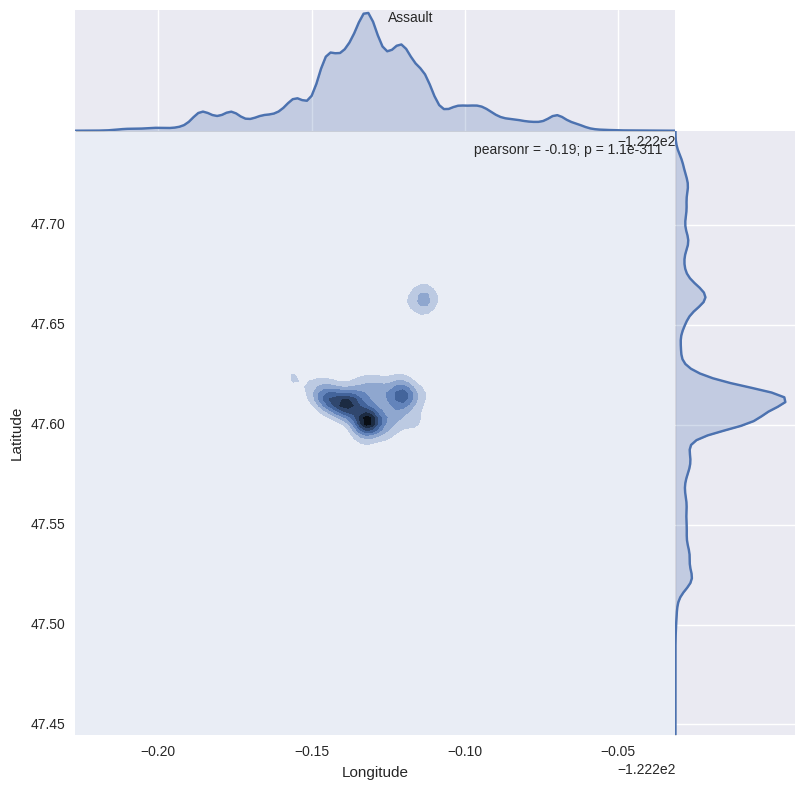

In [36]:
# Now let's take the vehicle theft description and plot it against the latitude and longitude using a kernel density estimate graph in Seaborn

plot = sns.jointplot("Longitude", "Latitude", data=assault, kind="kde", size=8, space=0)
plot.fig.suptitle("Assault")

In [14]:
train_df.AnimalType = train_df.AnimalType.map(animaltype)

So, now let's plot our outcomes against the animal type.

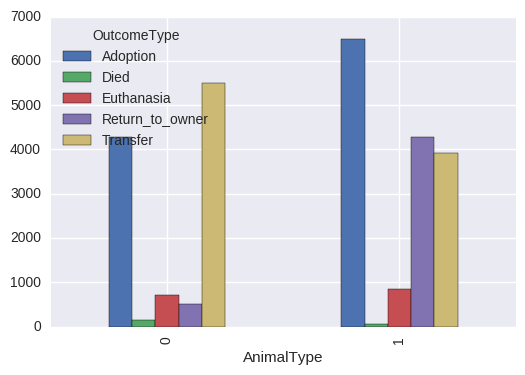

In [15]:
pd.crosstab(train_df.AnimalType, train_df.OutcomeType).plot.bar()

In [16]:
# So let's see what outcomes we're mapping against.

outcomes = train_df.OutcomeType.unique()
outcomes

array(['Return_to_owner', 'Euthanasia', 'Adoption', 'Transfer', 'Died'], dtype=object)

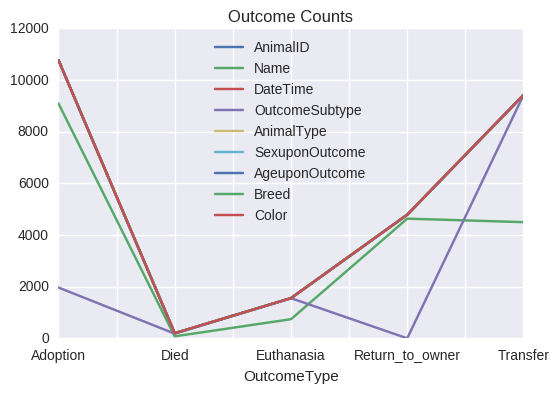

In [17]:
# Let's explore the data a bit more.  How do these outcomes map to our data?

counts = train_df.groupby('OutcomeType').count()
counts.plot.line(title="Outcome Counts")

Next we'll look at the outcome subtype. This isn't an element of our test data, so we shouldn't build it directly into our classifier, but we can use it to help us understand our data.

As an aside, this seems like very useful data to have on intake (and it bumps our accuracy up to 80+% when we use it).

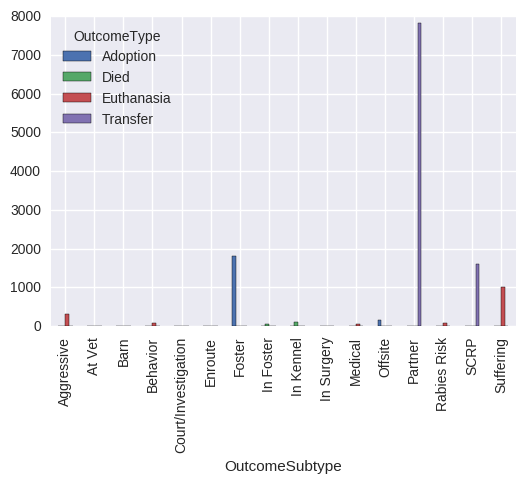

In [18]:
dates_cross = pd.crosstab(train_df.OutcomeSubtype, train_df.OutcomeType)
dates_cross.plot.bar()

Interesting. The outcome types are fairly siloed depending on the subtype.  Some questions:
* Where do transferred animals go?  Is shuffling them around an issue?  What are the outcomes after the transfer?
* At what point do the behavior, agression and suffering subtype outcomes come into play?

We need to transform the string categories into integers to work with the machine learning models.

Let's start by doing this for the animal sex feature.

In [19]:
# First, let's check out the different values

train_df.SexuponOutcome.unique()

array(['Neutered Male', 'Spayed Female', 'Intact Male', 'Intact Female',
       'Unknown', nan], dtype=object)

There are actually two variables in SexuponOutcome - whether or not the animal is neutered/spayed or not and then male and female.

Let's break this down.

In [20]:
intact_list = []
gender_list = []

def sort_sexuponoutcome(sex_string):
    try:
        intact, gender = sex_string.split()
    except (AttributeError, ValueError) as e:
        intact, gender = "Neutered Male".split()
    
    if intact == "Intact":
        intact_list.append(1)
    else:
        intact_list.append(0)
        
    if gender == "Male":
        gender_list.append(1)
    else:
        gender_list.append(0)


In [21]:
train_df.SexuponOutcome.apply(sort_sexuponoutcome)
len(intact_list)

26729

In [22]:
print(train_df.SexuponOutcome[:5], intact_list[:5], gender_list[:5])

0    Neutered Male
1    Spayed Female
2    Neutered Male
3      Intact Male
4    Neutered Male
Name: SexuponOutcome, dtype: object [0, 0, 0, 1, 0] [1, 0, 1, 1, 1]


In [23]:
train_df['Intact'] = intact_list
train_df['Gender'] = gender_list

In [24]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1 year,Shetland Sheepdog Mix,Brown/White,0,1
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1 year,Domestic Shorthair Mix,Cream Tabby,0,0
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2 years,Pit Bull Mix,Blue/White,0,1
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,3 weeks,Domestic Shorthair Mix,Blue Cream,1,1
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2 years,Lhasa Apso/Miniature Poodle,Tan,0,1


This seems like a good breakdown.

In [25]:
train_df.AgeuponOutcome.unique()

array(['1 year', '2 years', '3 weeks', '1 month', '5 months', '4 years',
       '3 months', '2 weeks', '2 months', '10 months', '6 months',
       '5 years', '7 years', '3 years', '4 months', '12 years', '9 years',
       '6 years', '1 weeks', '11 years', '4 weeks', '7 months', '8 years',
       '11 months', '4 days', '9 months', '8 months', '15 years',
       '10 years', '1 week', '0 years', '14 years', '3 days', '6 days',
       '5 days', '5 weeks', '2 days', '16 years', '1 day', '13 years', nan,
       '17 years', '18 years', '19 years', '20 years'], dtype=object)

And now we come to age.  This seems to be a text field, but pretty standard, so we'll just set up a quick function to group it into standard age groups (pulled from doggie websites). Possible issue: dogs of different sizes age differently. (Should we convert breed to size and modify the age feature?)

In [26]:
period_dict = {'year': 365, 'month': 30, 'week': 7, 'day': 1, 'day': 1}

age_group = {0: "infant", 1: "adolescent", 2: "adult", 3: "senior"}

def convert_age_to_group(age):
    # Convert input age into age groupings
    try:
        number, period = str(age).split()
        period = period.rstrip("s")
        days = int(number) * period_dict[period]
        
        if days < 365:
            return 0
        elif days < 730:
            return 1
        elif days < 2190:
            return 2
        else:
            return 3
        
    except ValueError:
        return 3
    

In [27]:
# Test our script

age_group[convert_age_to_group('8 weeks')]

'infant'

And we transform the AgeuponOutcome column to our groups.

In [28]:
train_df['AgeuponOutcome'] = train_df.AgeuponOutcome.apply(convert_age_to_group)

In [29]:
train_df.AgeuponOutcome.unique()

array([1, 2, 0, 3])

Now that we've grouped our data, let's look at how age effects outcome.

In [30]:
ages_n_outcomes = pd.crosstab(train_df.AgeuponOutcome, train_df.OutcomeType)

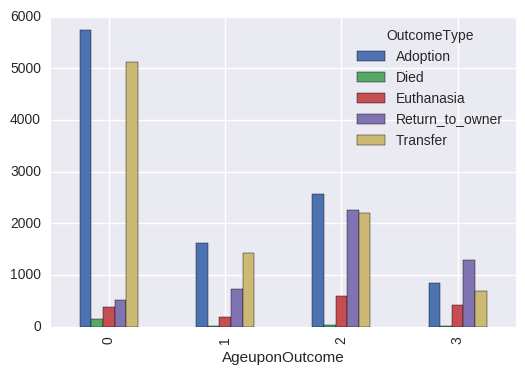

In [31]:
ages_n_outcomes.plot.bar()

Of interest here is the previous graph that showed that euthanized dogs were related to the OutcomeSubtypes for agression, etc.

So, we see that puppies are more likely to be adopted and adults are more likely to be euthanized, but looking at our counts again will help us interpret this data.

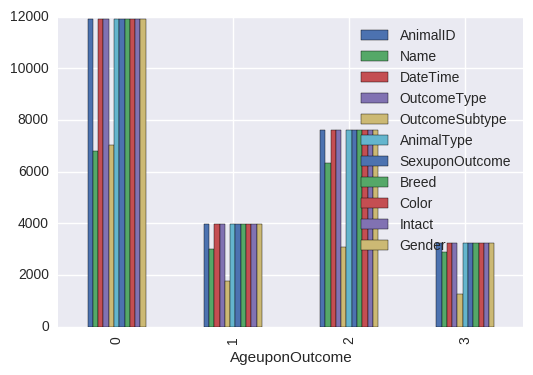

In [32]:
counts = train_df.groupby('AgeuponOutcome').count().plot.bar()

We should really do the same thing with color... But we're short on time here.

In [33]:
train_df.Color.unique()

array(['Brown/White', 'Cream Tabby', 'Blue/White', 'Blue Cream', 'Tan',
       'Black/Tan', 'Blue Tabby', 'Brown Tabby', 'Red/White', 'White',
       'Black', 'Silver', 'Brown', 'Black/Red', 'White/Cream',
       'Orange Tabby/White', 'Black/White', 'Brown Brindle/White',
       'Black/Brown', 'Orange Tabby', 'Chocolate/White', 'White/Tan',
       'Cream Tabby/White', 'Blue', 'Calico', 'Torbie', 'Brown/Black',
       'Yellow', 'Tricolor', 'White/Black', 'Tortie', 'Blue Tabby/White',
       'Gray/White', 'Tan/Black', 'Tan/White', 'Buff', 'Brown Tabby/White',
       'Red', 'Blue/Tan', 'Seal Point', 'Brown Brindle', 'White/Brown',
       'Gray', 'Yellow Brindle/White', 'Fawn/White', 'Flame Point',
       'Black Tabby/White', 'Tortie/Calico', 'Black/Brown Brindle',
       'White/Gray', 'Tan/Silver', 'Red Tick/Black', 'White/Cream Tabby',
       'Blue Merle', 'Chocolate/Tan', 'Sable', 'Brown Merle/White',
       'Brown Tiger/White', 'Liver/White', 'White/Blue Tabby',
       'Black/Gray', 'C

Some people really like their animals...  That is a lot of colours.

In [34]:
len(train_df.Color.unique())

366

We're still exploring here, so we will radically simplify the list.

In [35]:
def simplify_colors(color):
    sc = color.lower().replace("/"," ").split(" ")
    return sc[0]

In [36]:
simplify_colors("Black Brindle/Brown")

'black'

In [37]:
train_df.Color = train_df.Color.apply(simplify_colors)

In [38]:
len(train_df.Color.unique())

29

In [39]:
color = {}

transform_string_label_to_integer(color, train_df.Color)
    
train_df['Color'] = train_df.Color.map( color ).astype(int)

In [40]:
# We could also do something very cool with text analysis for names, but we'll keep it simple and go length

train_df['NameLength'] = train_df.Name.apply(lambda x: len(str(x)))

We've done a lot of pre-processing and have a good idea what our dataset looks like.  The Breed feature will be tricky, though, so let's save what we've done.

In [41]:
train_df.interpolate(inplace=True) # could have used dropna().median()
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1,Domestic Shorthair Mix,1,0,0,5
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2,Pit Bull Mix,2,0,1,6
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,0,Domestic Shorthair Mix,2,1,1,3
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2,Lhasa Apso/Miniature Poodle,3,0,1,3


In [42]:
# Save our clean dataframe to csv so we don't need to do this again.
train_df.to_csv(os.path.join(data_dir, "animals_clean_train.csv"))

### Gensim LSI for Breed types

In [43]:
# Let's reload our dataframe.

train_df = pd.read_csv(os.path.join(data_dir, "animals_clean_train.csv"), index_col=0)

In [44]:
train_df.head()

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7
1,A656520,Emily,2013-10-13 12:44:00,Euthanasia,Suffering,0,Spayed Female,1,Domestic Shorthair Mix,1,0,0,5
2,A686464,Pearce,2015-01-31 12:28:00,Adoption,Foster,1,Neutered Male,2,Pit Bull Mix,2,0,1,6
3,A683430,NaN,2014-07-11 19:09:00,Transfer,Partner,0,Intact Male,0,Domestic Shorthair Mix,2,1,1,3
4,A667013,NaN,2013-11-15 12:52:00,Transfer,Partner,1,Neutered Male,2,Lhasa Apso/Miniature Poodle,3,0,1,3


And look at the Breed feature.

In [45]:
len(train_df.Breed.unique())

1380

In [51]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

That is a lot of breeds...

### Document tokenization

In [46]:
def split_into_lemmas(message):
    # transform texts into tokens and preprocess
    words = TextBlob(message.replace("/", " ").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [52]:
breed_dict = train_df.Breed.apply(split_into_lemmas)

In [53]:
breed_dict[:5]

0           [shetland, sheepdog, mix]
1          [domestic, shorthair, mix]
2                    [pit, bull, mix]
3          [domestic, shorthair, mix]
4    [lhasa, apso, miniature, poodle]
Name: Breed, dtype: object

In [54]:
dictionary = corpora.Dictionary(breed_dict)
dictionary.save(os.path.join(data_dir, "breeds.dict"))
print(dictionary.token2id)

2016-11-05 21:12:44,884 INFO adding document #0 to Dictionary(0 unique tokens: [])
2016-11-05 21:12:44,964 INFO adding document #10000 to Dictionary(239 unique tokens: ['cattle', 'bullmastiff', 'cardigan', 'picardy', 'siberian']...)
2016-11-05 21:12:45,042 INFO adding document #20000 to Dictionary(256 unique tokens: ['cattle', 'bullmastiff', 'cardigan', 'picardy', 'siberian']...)
2016-11-05 21:12:45,094 INFO built Dictionary(262 unique tokens: ['cattle', 'bullmastiff', 'cardigan', 'picardy', 'siberian']...) from 26729 documents (total 80871 corpus positions)
2016-11-05 21:12:45,095 INFO saving Dictionary object under /home/chris/data/breeds.dict, separately None
2016-11-05 21:12:45,096 INFO saved /home/chris/data/breeds.dict


{'cattle': 71, 'bullmastiff': 147, 'cardigan': 50, 'picardy': 203, 'siberian': 70, 'coonhound': 56, 'harrier': 111, 'entlebucher': 235, 'swiss': 144, 'forest': 249, 'otterhound': 233, 'basenji': 159, 'cairn': 11, 'coat': 21, 'pixiebob': 220, 'terrier': 13, 'eskimo': 176, 'cur': 41, 'dogue': 95, 'toy': 146, 'akita': 93, 'treeing': 58, 'fox': 148, 'bedlington': 225, 'rough': 109, 'van': 245, 'pointing': 230, 'weimaraner': 120, 'turkish': 244, 'munchkin': 241, 'wire': 179, 'glen': 218, 'staffordshire': 30, 'sealyham': 239, 'angora': 19, 'japanese': 213, 'bruss': 135, 'brindle': 212, 'greyhound': 101, 'presa': 221, 'pembroke': 145, 'leonberger': 192, 'silky': 133, 'feist': 231, 'burmese': 132, 'whippet': 77, 'tervuren': 255, 'mix': 0, 'malinois': 174, 'bombay': 181, 'wirehair': 102, 'elkhound': 247, 'field': 201, 'cane': 216, 'hound': 27, 'pharaoh': 209, 'bay': 78, 'schnauzer': 15, 'shih': 87, 'walker': 57, 'samoyed': 232, 'frise': 141, 'retriever': 20, 'sphynx': 236, 'bichon': 140, 'lowch

Now we set up to pre-process the breed tokens and get them ready for analysis.

In [55]:
stoplist = '''
mix blend mutt black blue red white brown orange st terr de tan smooth
soft dog long short hair
'''.split()

stop_ids = [dictionary.token2id[stopword] for stopword in stoplist 
            if stopword in dictionary.token2id]
once_ids = [tokenid for tokenid, docfreq in dictionary.dfs.items() if docfreq == 1]
dictionary.filter_tokens(stop_ids + once_ids) # remove stop words and words that appear only once
dictionary.compactify() # remove gaps in id sequence after words that were removed
print(dictionary)

Dictionary(228 unique tokens: ['cattle', 'bullmastiff', 'cardigan', 'picardy', 'siberian']...)


Some of the issues here:

* Some of the breeds have colours including (which double counts the feature)
* There are a lot of generic terms, like mix & medium that don't add very much value.

In [56]:
corpus = [dictionary.doc2bow(text) for text in breed_dict]

In [57]:
corpora.MmCorpus.serialize(os.path.join(data_dir, "breed_corpus.mm"), corpus)
print(len(corpus))

2016-11-05 21:12:59,615 INFO storing corpus in Matrix Market format to /home/chris/data/breed_corpus.mm
2016-11-05 21:12:59,616 INFO saving sparse matrix to /home/chris/data/breed_corpus.mm
2016-11-05 21:12:59,616 INFO PROGRESS: saving document #0
2016-11-05 21:12:59,622 INFO PROGRESS: saving document #1000
2016-11-05 21:12:59,629 INFO PROGRESS: saving document #2000
2016-11-05 21:12:59,637 INFO PROGRESS: saving document #3000
2016-11-05 21:12:59,647 INFO PROGRESS: saving document #4000
2016-11-05 21:12:59,652 INFO PROGRESS: saving document #5000
2016-11-05 21:12:59,658 INFO PROGRESS: saving document #6000
2016-11-05 21:12:59,663 INFO PROGRESS: saving document #7000
2016-11-05 21:12:59,669 INFO PROGRESS: saving document #8000
2016-11-05 21:12:59,675 INFO PROGRESS: saving document #9000
2016-11-05 21:12:59,681 INFO PROGRESS: saving document #10000
2016-11-05 21:12:59,688 INFO PROGRESS: saving document #11000
2016-11-05 21:12:59,693 INFO PROGRESS: saving document #12000
2016-11-05 21:12:

26729


Okay, so we have our corpus, but we still don't know the right number of topics.  For this we'll use Latent Semantic Indexing (LSI) via Sklearn.  The code here is pulled from a great "Topic Modelling with Gensim" in the Salmon Run page.

http://sujitpal.blogspot.ca/2014/08/topic-modeling-with-gensim-over-past.html

Next we need to set up a Term-frequency, inverse document frequency transformer. This is a statistical way of determining which words are most important out of a corpus.

You can learn more about feature extraction here: http://scikit-learn.org/stable/modules/feature_extraction.html

In [58]:
tfidf = models.TfidfModel(corpus, normalize=True)
corpus_tfidf = tfidf[corpus]
print(len(corpus_tfidf), len(train_df))

2016-11-05 21:13:07,959 INFO collecting document frequencies
2016-11-05 21:13:07,959 INFO PROGRESS: processing document #0
2016-11-05 21:13:07,965 INFO PROGRESS: processing document #10000
2016-11-05 21:13:07,970 INFO PROGRESS: processing document #20000
2016-11-05 21:13:07,974 INFO calculating IDF weights for 26729 documents and 227 features (56182 matrix non-zeros)


26729 26729


In [59]:
def split_into_lemmas(message):
    # transform texts into tokens and preprocess
    words = TextBlob(message.replace("/", " ").lower()).words
    # for each word, take its "base form" = lemma 
    return [word.lemma for word in words]

In [60]:
# Project to 2 dimensions for visualization
lsi = models.lsimodel.LsiModel(corpus_tfidf, id2word=dictionary, 
                               num_topics=2)

2016-11-05 21:13:16,164 INFO using serial LSI version on this node
2016-11-05 21:13:16,165 INFO updating model with new documents
2016-11-05 21:13:16,378 INFO preparing a new chunk of documents
2016-11-05 21:13:16,429 INFO using 100 extra samples and 2 power iterations
2016-11-05 21:13:16,429 INFO 1st phase: constructing (228, 102) action matrix
2016-11-05 21:13:16,508 INFO orthonormalizing (228, 102) action matrix
2016-11-05 21:13:16,570 INFO 2nd phase: running dense svd on (102, 20000) matrix
2016-11-05 21:13:16,686 INFO computing the final decomposition
2016-11-05 21:13:16,687 INFO keeping 2 factors (discarding 57.060% of energy spectrum)
2016-11-05 21:13:16,687 INFO processed documents up to #20000
2016-11-05 21:13:16,688 INFO topic #0(82.586): -0.734*"domestic" + -0.676*"shorthair" + -0.059*"chihuahua" + -0.019*"medium" + -0.012*"longhair" + -0.003*"dachshund" + -0.001*"terrier" + -0.000*"siamese" + -0.000*"rat" + -0.000*"pug"
2016-11-05 21:13:16,689 INFO topic #1(40.295): 0.700*"

In [61]:
len(lsi[corpus])

26729

In [62]:
# write out coordinates to file
fcoords = open(os.path.join(data_dir, "coords.csv"), 'w')
for vector in lsi[corpus]:
    if len(vector) != 2:
        continue
    fcoords.write("%6.4f\t%6.4f\n" % (vector[0][1], vector[1][1]))
fcoords.close()

In [63]:
from sklearn.cluster import KMeans

The following graph runs a KMeans analysis against different K values and graphs the inertia.  When we start hitting diminishing returns, we know we're close to our optimal number of clusters.

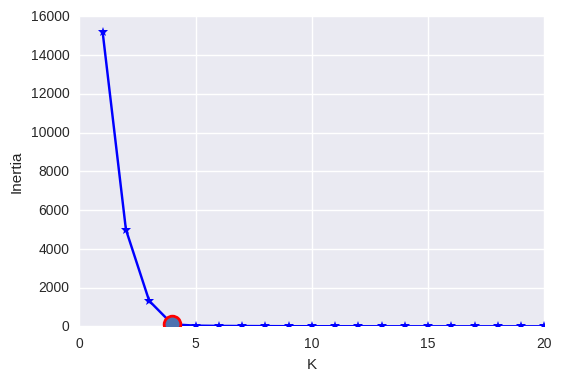

In [64]:
MAX_K = 20

X = X = np.loadtxt(os.path.join(data_dir, "coords.csv"), delimiter="\t")
ks = range(1, MAX_K + 1)

inertias = np.zeros(MAX_K)
diff = np.zeros(MAX_K)
diff2 = np.zeros(MAX_K)
diff3 = np.zeros(MAX_K)
for k in ks:
    kmeans = KMeans(k).fit(X)
    inertias[k - 1] = kmeans.inertia_
    # first difference    
    if k > 1:
        diff[k - 1] = inertias[k - 1] - inertias[k - 2]
    # second difference
    if k > 2:
        diff2[k - 1] = diff[k - 1] - diff[k - 2]
    # third difference
    if k > 3:
        diff3[k - 1] = diff2[k - 1] - diff2[k - 2]

elbow = np.argmin(diff3[3:]) + 3

plt.plot(ks, inertias, "b*-")
plt.plot(ks[elbow], inertias[elbow], marker='o', markersize=12,
         markeredgewidth=2, markeredgecolor='r', markerfacecolor=None)
plt.ylabel("Inertia")
plt.xlabel("K")
plt.show()

From the graph above, we can see that 4 clusters seems to be optimal for our analysis of breeds. Let's graph the 4 clusters now.

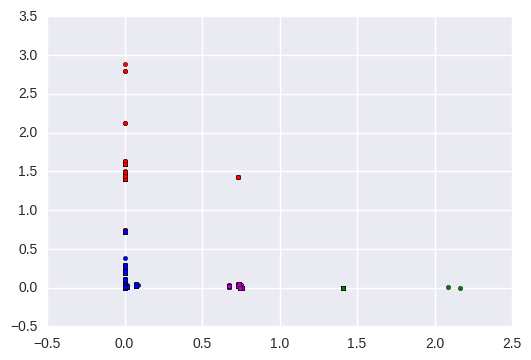

In [65]:
# Rerun Kmeans with num_topics = 4
NUM_TOPICS = 4

X = np.loadtxt(os.path.join(data_dir, "coords.csv"), delimiter="\t")
kmeans = KMeans(NUM_TOPICS).fit(X)
y = kmeans.labels_

colors = ["b", "g", "r", "m"]
for i in range(X.shape[0]):
    plt.scatter(X[i][0], X[i][1], c=colors[y[i]], s=10)    
plt.show()

Okay, so we're now reasonably solid that we should have four topics, so let's run the LDA and look at our top topics.

In [66]:
lda = models.ldamulticore.LdaMulticore(corpus=corpus, id2word=dictionary,
                         num_topics=4, passes=10)

lda.top_topics(corpus)

2016-11-05 21:14:53,108 INFO using symmetric alpha at 0.25
2016-11-05 21:14:53,109 INFO using symmetric eta at 0.25
2016-11-05 21:14:53,109 INFO using serial LDA version on this node
2016-11-05 21:14:53,120 INFO running online LDA training, 4 topics, 10 passes over the supplied corpus of 26729 documents, updating every 14000 documents, evaluating every ~26729 documents, iterating 50x with a convergence threshold of 0.001000
2016-11-05 21:14:53,122 INFO training LDA model using 7 processes
2016-11-05 21:14:53,171 INFO PROGRESS: pass 0, dispatched chunk #0 = documents up to #2000/26729, outstanding queue size 1
2016-11-05 21:14:53,174 INFO PROGRESS: pass 0, dispatched chunk #1 = documents up to #4000/26729, outstanding queue size 2
2016-11-05 21:14:53,175 INFO PROGRESS: pass 0, dispatched chunk #2 = documents up to #6000/26729, outstanding queue size 3
2016-11-05 21:14:53,178 INFO PROGRESS: pass 0, dispatched chunk #3 = documents up to #8000/26729, outstanding queue size 4
2016-11-05 21:

[([(0.26709203602048476, 'retriever'),
   (0.24737502592835145, 'labrador'),
   (0.055327092276223344, 'collie'),
   (0.054668094994019312, 'border'),
   (0.030063478553472106, 'american'),
   (0.027129282454809812, 'staffordshire'),
   (0.024198690314255023, 'bulldog'),
   (0.020740019700649107, 'shih'),
   (0.020739538054131292, 'tzu'),
   (0.019888625977436829, 'great'),
   (0.019582276574470422, 'welsh'),
   (0.018521734188398649, 'corgi'),
   (0.016201752068681047, 'anatol'),
   (0.014126710823421295, 'cardigan'),
   (0.013307279216233245, 'golden'),
   (0.012506590081545981, 'pyrenees'),
   (0.0085744351384471808, 'doberman'),
   (0.0085739012008069857, 'pinsch'),
   (0.0071357476922202824, 'coat'),
   (0.0064248322903039841, 'dane')],
  -873.55976818455497),
 ([(0.18338058202834268, 'bull'),
   (0.17967192005012123, 'pit'),
   (0.12530540998958639, 'terrier'),
   (0.076645717412488101, 'australian'),
   (0.048090434255968588, 'cattle'),
   (0.032295587407524924, 'siamese'),
   (

This actually looks pretty good... except I can't find the cats and, at minimum, they've been grouped together with the dogs.  Because we are predicting based on animaltype as well, this might not be as serious an issue as it appears.

Now we create a bag of words transformer based on the full texts in the Breed feature.

In [67]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
count_vect = CountVectorizer()

bow_transformer = CountVectorizer(analyzer=split_into_lemmas).fit(train_df.Breed)
len(bow_transformer.vocabulary_)

bow_transformer.get_feature_names()[3]

breed_bow = bow_transformer.transform(train_df.Breed)
print( 'sparse matrix shape:', breed_bow.shape)
print( 'number of non-zeros:', breed_bow.nnz)
print ('sparsity: %.2f%%' % (100.0 * breed_bow.nnz / (breed_bow.shape[0] * breed_bow.shape[1])))

# First, we fit the transformer to our BoW

tfidf_transformer = TfidfTransformer().fit(breed_bow)

breed_tfidf = tfidf_transformer.transform(breed_bow)

for e in breed_tfidf[5]:
    print(e)

sparse matrix shape: (26729, 262)
number of non-zeros: 80537
sparsity: 1.15%
  (0, 237)	0.470921349262
  (0, 214)	0.22922693304
  (0, 58)	0.41279380185
  (0, 47)	0.745177410509


From here, we can cluster the breed data using several options.

## KMeans Clustering

Let's do this again using our previous code, just for kicks.

In [68]:
# Select number of clusters for KMeans clustering - now 4 clusters
n_clusters = 4

In [69]:
# Import and set up our classifier

from sklearn.cluster import KMeans

km = KMeans(n_clusters=n_clusters, init='k-means++', n_init=1, verbose=1)

In [70]:
# Fit the KM classifier on our TFIDF

km_breeds = km.fit_predict(breed_tfidf)

Initialization complete
Iteration  0, inertia 22925.014
Iteration  1, inertia 16125.799
Iteration  2, inertia 16050.225
Iteration  3, inertia 16047.942
Iteration  4, inertia 16047.246
Iteration  5, inertia 16046.956
Iteration  6, inertia 16046.775
Iteration  7, inertia 16046.446
Iteration  8, inertia 16045.595
Iteration  9, inertia 16023.044
Iteration 10, inertia 15945.452
Iteration 11, inertia 15937.442
Iteration 12, inertia 15937.386
Iteration 13, inertia 15937.384
Converged at iteration 13


KMeans stops when it stops making progress on it's clustering.

Now we have a working machine learning classifier on which we can predict our feature.

In [71]:
km.predict(breed_tfidf[4])

array([0], dtype=int32)

In [72]:
train_df['BreedKMeans'] = km_breeds

In [73]:
train_df.head(1)

,AnimalID,Name,DateTime,OutcomeType,OutcomeSubtype,AnimalType,SexuponOutcome,AgeuponOutcome,Breed,Color,Intact,Gender,NameLength,BreedKMeans
0,A671945,Hambone,2014-02-12 18:22:00,Return_to_owner,NaN,1,Neutered Male,1,Shetland Sheepdog Mix,0,0,1,7,0


In [74]:
train_df.columns

Index(['AnimalID', 'Name', 'DateTime', 'OutcomeType', 'OutcomeSubtype',
       'AnimalType', 'SexuponOutcome', 'AgeuponOutcome', 'Breed', 'Color',
       'Intact', 'Gender', 'NameLength', 'BreedKMeans'],
      dtype='object')

In [75]:
X = train_df.drop(['AnimalID', 'Name', "DateTime", "OutcomeSubtype",
                  "SexuponOutcome", 'Breed', ], axis=1)

X.dtypes

OutcomeType       object
AnimalType         int64
AgeuponOutcome     int64
Color              int64
Intact             int64
Gender             int64
NameLength         int64
BreedKMeans        int32
dtype: object

In [76]:
X.head()

,OutcomeType,AnimalType,AgeuponOutcome,Color,Intact,Gender,NameLength,BreedKMeans
0,Return_to_owner,1,1,0,0,1,7,0
1,Euthanasia,0,1,1,0,0,5,0
2,Adoption,1,2,2,0,1,6,1
3,Transfer,0,0,2,1,1,3,0
4,Transfer,1,2,3,0,1,3,0


In [77]:
X.to_csv(os.path.join(data_dir, "prepared_animals_df.csv"))

In [78]:
# Visualizing the K-Means clusters via TSNE
# t-distributed Stochastic Neighbor Embedding.

from sklearn.manifold import TSNE

http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

In [79]:
# First we use the TruncatedSVD to perform linear dimensionality reduction (truncated singular value decomposition (SVD)).

from sklearn.decomposition import TruncatedSVD

X_reduced = TruncatedSVD(n_components=50, random_state=0).fit_transform(breed_tfidf)

In [80]:
# Note - you need a fairly high-powered system to run the TSNE with this dataset. An i7 with 16gb ram works fine.
# N_components refers to bringing the multi-dimensional space down to 2 dimensions, which lets us graph it.

X_embedded = TSNE(n_components=2, perplexity=40, verbose=2).fit_transform(X_reduced)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 26729
[t-SNE] Computed conditional probabilities for sample 2000 / 26729
[t-SNE] Computed conditional probabilities for sample 3000 / 26729
[t-SNE] Computed conditional probabilities for sample 4000 / 26729
[t-SNE] Computed conditional probabilities for sample 5000 / 26729
[t-SNE] Computed conditional probabilities for sample 6000 / 26729
[t-SNE] Computed conditional probabilities for sample 7000 / 26729
[t-SNE] Computed conditional probabilities for sample 8000 / 26729
[t-SNE] Computed conditional probabilities for sample 9000 / 26729
[t-SNE] Computed conditional probabilities for sample 10000 / 26729
[t-SNE] Computed conditional probabilities for sample 11000 / 26729
[t-SNE] Computed conditional probabilities for sample 12000 / 26729
[t-SNE] Computed conditional probabilities for sample 13000 / 26729
[t-SNE] Computed conditional probabilities

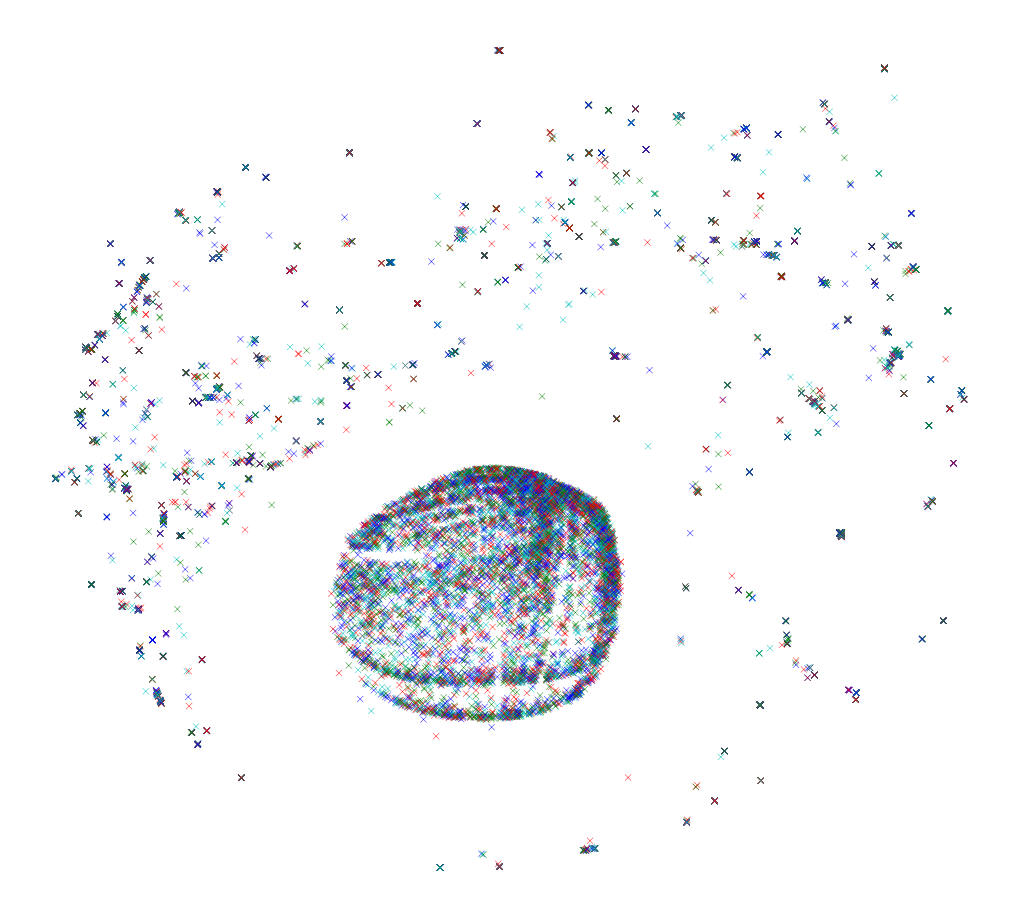

In [81]:
fig = plt.figure(figsize=(10, 10))
ax = plt.axes(frameon=False)
plt.setp(ax, xticks=(), yticks=())
plt.subplots_adjust(left=0.0, bottom=0.0, right=1.0, top=0.9,
                wspace=0.0, hspace=0.0)
plt.scatter(X_embedded[:, 0], X_embedded[:, 1],
            c=['g', 'b', 'r', 'c'], marker="x")

This plot looks significantly different from our previous plot with only dog breeds. We've also done a deeper analysis, so the difference makes sense, but I would have expected to see greater differentiation in the clusters.

### Frome here, go to the Random Forest Classifier to try out your machine learning model.